## Modelling

### Imports

In [95]:
# imports
import pandas as pd
import numpy as np
import sqlite3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     StratifiedKFold,
                                     GridSearchCV)

from sklearn.linear_model import (LogisticRegression, 
                                  LassoCV, 
                                  Lasso)

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (RandomForestClassifier, 
                                BaggingClassifier)
from nltk.stem.porter import *
from  nltk.stem import PorterStemmer

from sklearn.metrics import (precision_score,
                             f1_score,
                             recall_score,
                             accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay, 
                             classification_report,
                             roc_curve,
                             auc)

from matplotlib import pyplot as plt
np.random.seed(73)

### Functions

In [3]:
def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=73,
                         shuffle=True)
    s = cross_val_score(model, X, y, cv=cv,
                        n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, 
                                              s.mean(), 
                                              2 * s.std()))

In [128]:
# confusion matrix
def con_matrix(model, X, y, title):
    conmat = np.array(confusion_matrix(y, 
                                       model.predict(X), 
                                       labels=[0, 1]))

    print(classification_report(y,
                        model.predict(X), 
                        zero_division=True,
                        target_names=['Not Useful', 'Useful']))

    matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                            display_labels=['Not useful','useful'])
    matrix_display.plot()

    figure = plt.gcf()
    plt.title(title)
    figure.set_size_inches(8, 8)

In [136]:

def roc_plot(model, X, y, title):
    y_proba = model.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_proba[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=[8,8])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC for Useful Reviews ({})'.format(title), fontsize=16)
    plt.legend(loc="lower right")
    ;

## Baseline

In [6]:
# load data
db_con = sqlite3.connect('../../part-02/data/yelp.db.sqlite')

In [7]:
# create dataframe
reviews = pd.DataFrame(pd.read_sql('select * from \
reviews_cleaned;',
           con=db_con))

In [8]:
reviews.target.value_counts(normalize=True)

0    0.555053
1    0.444947
Name: target, dtype: float64

The baseline of the target is 0.56, for reviews with zero useful votes.

### Pre-processing

In [9]:
# apply stemmer
stemmer = PorterStemmer()
reviews['text'] = reviews['text'].apply(lambda x: stemmer.stem(x))

In [10]:
## instantiate vectorizer
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 200,
                       max_df = .60,
                       norm = 'l2'
                      )
tvec.fit(reviews.text)

TfidfVectorizer(max_df=0.6, max_features=200, stop_words='english',
                strip_accents='ascii')

In [11]:
# create vectorized dataframe
reviews_tvec = pd.DataFrame(tvec.transform(reviews.text).todense(),
                  columns = tvec.get_feature_names())

In [12]:
# add target to tvec data
reviews_tvec['target'] = reviews.target

In [13]:
# instsantiate X and y for tvec data
X_tvec = reviews_tvec.drop(['target'], axis = 1)
y_tvec = reviews_tvec.target

***Note*** we are using lasso to reduce collumns

In [14]:
# instantiate LassoCV model
lasso_cv = LassoCV(cv=5, max_iter=10000, tol=0.001)\
.fit(X_tvec, y_tvec)

In [15]:
# fit model and generate columns for modelling
new_lasso = Lasso(alpha=lasso_cv.alpha_)

new_lasso.fit(X_tvec, y_tvec)

final_col_for_modeling_best_alpha = [col for col, \
        coef in zip(X_tvec.columns, new_lasso.coef_) if coef]

In [16]:
# generate new dataframe using final columns
reviews_tvec = reviews_tvec[final_col_for_modeling_best_alpha]

In [17]:
# concat vectorized and reviews dataframes
reviews_final = pd.concat([reviews,reviews_tvec],axis=1)

In [43]:
# instantiate X and y
X = reviews_final.drop(['review_id', 'user_id', 'business_id', 
                        'date','text','useful','target'], axis=1)
y = reviews_final.target

In [45]:
# set up train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size=0.2, random_state=73)

In [46]:
# standard scale the data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)

X_test_ss = ss.transform(X_test)

### Logistic Regression Model

In [47]:
# set up gridsearch params
log_params = {'C': [10.0, 100.0]}

# Instantiate GridSearchCV object.
log_grid = GridSearchCV(LogisticRegression(),
                              log_params,
                              cv=5,
                              verbose=0)

In [48]:
# run gridsearch
log_grid.fit(X_train_ss, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [10.0, 100.0]})

In [64]:
print(str(log_grid.best_score_) + ' best score')
print(str(log_grid.best_estimator_) + ' best model')
print(str(log_grid.best_params_) + ' best params')

0.6228724655016509 best score
LogisticRegression(C=100.0) best model
{'C': 100.0} best params


In [50]:
lr = LogisticRegression(solver='liblinear',
                       C=10,
                       penalty='l2',
                       random_state=73
                       )

lr.fit(X_train_ss, y_train)

LogisticRegression(C=10, random_state=73, solver='liblinear')

In [73]:
{feature: importance for feature, importance in zip(X.columns, 
                                lr.coef_[0])}


{'stars': 0.011020641675220912,
 'num_words': -0.08037249575312072,
 'num_chars': 0.46037616310192647,
 '10': 0.0357688720766842,
 'absolutely': 0.005295384814105092,
 'actually': 0.023962412466421442,
 'amazing': -0.020640632829300516,
 'area': 0.0013566430002849804,
 'ask': -0.009400132142171431,
 'atmosphere': -0.06199192844309234,
 'away': 0.003230171406548237,
 'awesome': -0.024800613134699844,
 'bad': 0.01924095704348621,
 'bar': 0.03228343204132346,
 'beer': 0.005432089571074677,
 'best': 0.003467518293732753,
 'better': 0.003410594750995316,
 'big': 0.017792054103906885,
 'bit': 0.013876365883553147,
 'bread': 0.027708459184038352,
 'breakfast': 0.006519389021454949,
 'burger': -0.009474940578123071,
 'business': 0.01607014409907883,
 'busy': 0.009095116813814162,
 'called': 0.026976155668239528,
 'came': -0.002648619775627772,
 'car': 0.04577305332749927,
 'care': 0.009888920714745838,
 'check': 0.021148427265499294,
 'cheese': 0.00932036121208762,
 'chicken': -0.0099805747274

- An increase in one standard deviation num_words is associated with 0.92 decrease in the odds of a useful post.

- An increase in one standard deviation atmosphere is associated with 0.94 decrease in the odds of a useful post.

- An increase in one standard deviation food is associated with 0.95 decrease in the odds of a useful post.

- An increase in one standard deviation server is associated with 0.96 decrease in the odds of a useful post.

- An increase in one standard deviation table is associated with 0.96 decrease in the odds of a useful post.

- An increase in one standard deviation num_chars is associated with 1.58 increase in the odds of a useful post.

- An increase in one standard deviation need is associated with 1.07 increase in the odds of a useful post.

- An increase in one standard deviation new is associated with 1.06 increase in the odds of a useful post.

- An increase in one standard deviation store is associated with 1.06 increase in the odds of a useful post.

- An increase in one standard deviation shop is associated with 1.06 increase in the odds of a useful post.

### Logistic regression Metrics

In [130]:
# score the X_train
score(lr, 'Logistic regression', X_train_ss, y_train)

Logistic regression Score: 0.62 +- 0.024


In [131]:
# score the X_test
score(lr, 'Logistic regression', X_test_ss, y_test)

Logistic regression Score: 0.62 +- 0.036


              precision    recall  f1-score   support

  Not Useful       0.64      0.77      0.70      2327
      Useful       0.61      0.45      0.52      1831

    accuracy                           0.63      4158
   macro avg       0.63      0.61      0.61      4158
weighted avg       0.63      0.63      0.62      4158



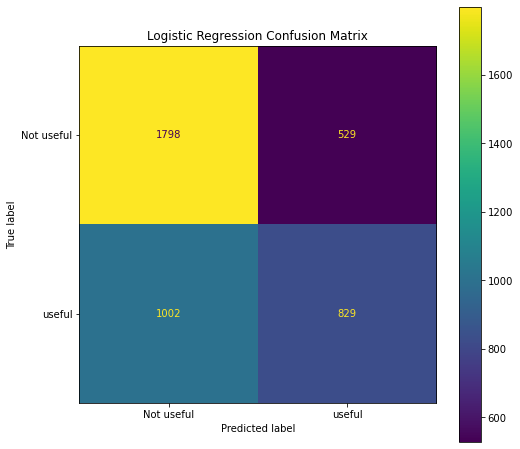

In [150]:
con_matrix(lr, X_test_ss, y_test, 'Logistic Regression Confusion Matrix')

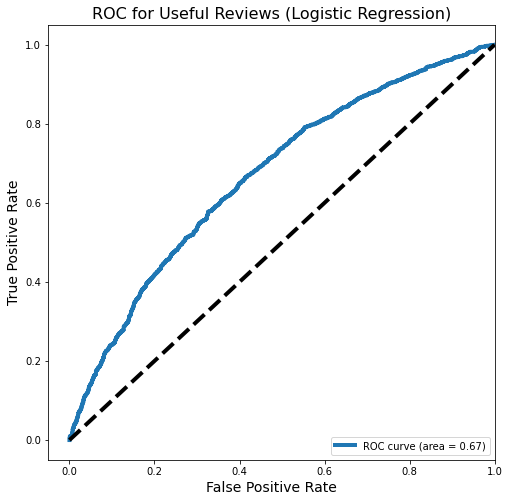

In [137]:
roc_plot(lr, X_test_ss, y_test, 'Logistic Regression')

The logistic regression model had an r-squared score of 0.62 +/- 0.036 for training data, while the test data scored slightly better with 0.62 +/- 0.038.  For precision, out of all the reviews that the model predicted would be useful, only 61% actually were.  For recall, out of all the reviews that actually were useful, the model predicted this outcome correctly for 61% of those reviews.  For the F-1 score, this value isn’t very close to 1, it tells us that the model does a poor job of predicting whether or not reviews will be useful.  The ROC score is below the acceptable range of 0.7+.

### Random Forest Model

In [140]:
# set up gridsearch params
forest_params = {'n_estimators': [10, 50, 100, 200],
                    'min_samples_leaf': [1, 5, 10]
                }

# Instantiate GridSearchCV object.
forest_grid = GridSearchCV(RandomForestClassifier(),
                              forest_params,
                              cv=5,
                              verbose=0)

In [141]:
# run gridsearch
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [10, 50, 100, 200]})

In [143]:
print(str(forest_grid.best_score_) + ' best score')
print(str(forest_grid.best_params_) + ' best params')

0.6349582426694905 best score
{'min_samples_leaf': 10, 'n_estimators': 50} best params


In [144]:
# instantiate and fit
rf = RandomForestClassifier(n_jobs=-1,
                            random_state=73,
                            n_estimators=50,
                            min_samples_leaf=10,
                            warm_start=True)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=10, n_estimators=50, n_jobs=-1,
                       random_state=73, warm_start=True)

In [145]:
{feature: importance for feature, importance in zip(X.columns, 
                                    rf.feature_importances_)}

{'stars': 0.001294538191432103,
 'num_words': 0.11685260383951282,
 'num_chars': 0.11677524836049062,
 '10': 0.002323678810929376,
 'absolutely': 0.0014954066866299965,
 'actually': 0.002424080542226686,
 'amazing': 0.007106464045846962,
 'area': 0.004301568203339695,
 'ask': 0.0014674185937507995,
 'atmosphere': 0.007427406897757289,
 'away': 0.002376169161528532,
 'awesome': 0.0038172353978293667,
 'bad': 0.004217533047841527,
 'bar': 0.004645439766099847,
 'beer': 0.0019119195393241914,
 'best': 0.008603199689902884,
 'better': 0.004668486351722934,
 'big': 0.0020808316520513517,
 'bit': 0.002206936740808826,
 'bread': 0.0016463156069798236,
 'breakfast': 0.001763260145038728,
 'burger': 0.001541762589594377,
 'business': 0.0015577461149859743,
 'busy': 0.0014298005831487014,
 'called': 0.00260112794869594,
 'came': 0.005783582287833341,
 'car': 0.001604379022082095,
 'care': 0.0009815981084642185,
 'check': 0.0023309154409552842,
 'cheese': 0.0031705412130878783,
 'chicken': 0.0059

The top 5 features of importance are:
- num_words: 0.116852603839513
- num_chars: 0.116775248360491
- great: 0.0219457440853888
- food: 0.021819203442455
- like: 0.0185179958853776

The bottom 5 features of importance are:
- rice:	0.0008681280395603
- house: 0.000835254650819013
- soup:	0.000777326018836878
- sushi: 0.000769274024751508
- inside: 0.000595344306760098

### Random Forest Metrics

In [147]:
# score the X_train
score(rf, 'Random Forest', X_train, y_train)

Random Forest Score: 0.63 +- 0.018


In [148]:
# score the X_test
score(rf, 'Random Forest', X_test, y_test)

Random Forest Score: 0.64 +- 0.036


              precision    recall  f1-score   support

  Not Useful       0.66      0.71      0.69      2327
      Useful       0.60      0.54      0.57      1831

    accuracy                           0.64      4158
   macro avg       0.63      0.63      0.63      4158
weighted avg       0.63      0.64      0.63      4158



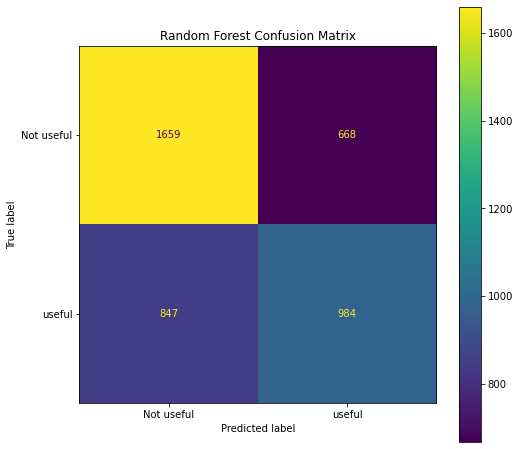

In [149]:
con_matrix(rf, X_test, y_test, 'Random Forest Confusion Matrix')

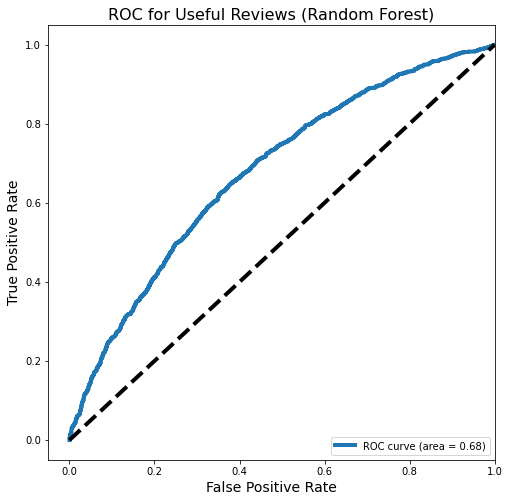

In [151]:
roc_plot(rf, X_test, y_test, 'Random Forest')

The random forest model had an r-squared score of 0.63 +/- 0.018 for training data, while the test data scored slightly better with 0.64 +/- 0.036.  For precision, out of all the reviews that the model predicted would be useful, only 60% actually were.  For recall, out of all the reviews that actually were useful, the model predicted this outcome correctly for 54% of those reviews.  For the F-1 score, this value isn’t very close to 1, it tells us that the model does a poor job of predicting whether or not reviews will be useful.  The ROC score is slightly below the acceptable range of 0.7+.  The model is better at predicting true negatives over true positives. The model performs slightly worse than the regression model for predicting true negatives, and slightly better than the regression model for predicting true positives. 
